# Liesel-GAM Demo Notebook

## Setup and Imports

In [7]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [8]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

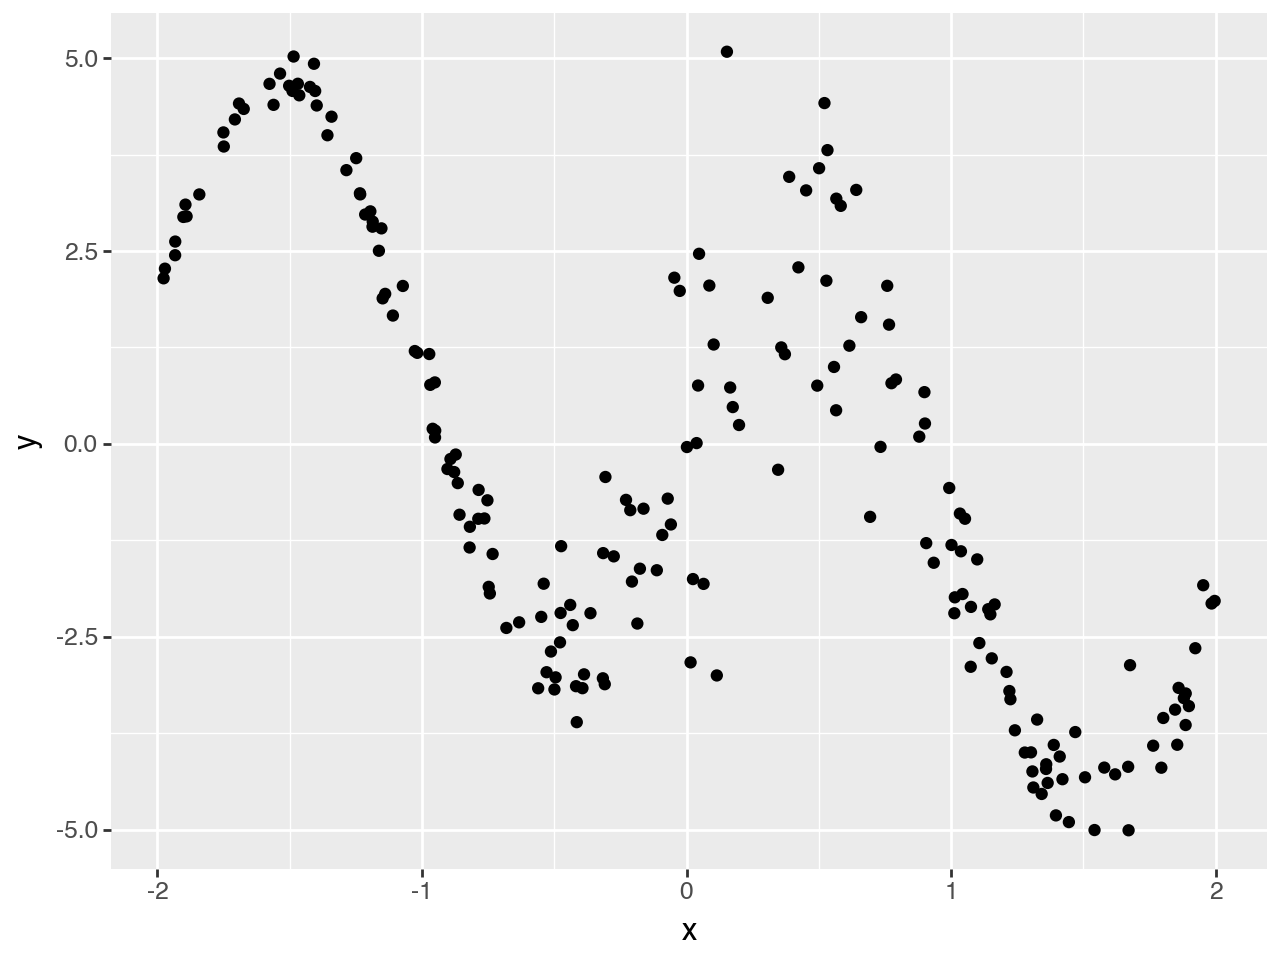

In [9]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [10]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
# import tensorflow_probability.substrates.jax.bijectors as tfb

# tau = lsl.Var.new_param(
#     1.0,
#     lsl.Dist(tfd.HalfNormal, scale=10.0),
#     name="$\\tau$",
# )
# tau.transform(
#     bijector=tfb.Exp(), inference=gs.MCMCSpec(gs.HMCKernel), name="$\\ln \\tau$"
# )

# loc += tb.s("x", bs="cp", scale=tau)
loc += tb.s("x", bs="tp")
scale += tb.s("x", bs="tp")

### Build and plot model

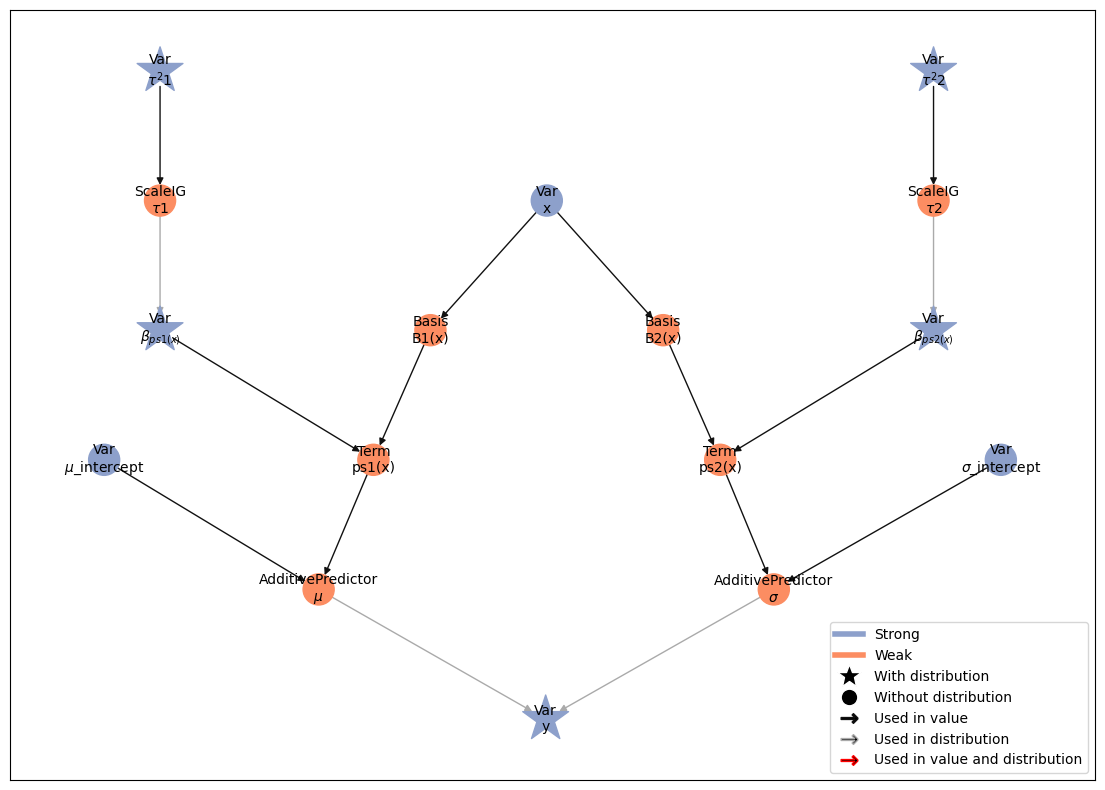

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\beta_{ps2(x)}$', '$\\tau^2$2', '$\\mu$_intercept', '$\\beta_{ps1(x)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.48chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 972.71chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 1, 1, 0, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel        mean          sd      q_0.05  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   kernel_04   -6.765389    4.364732  -14.011139   
                   (1,)   kernel_04   -9.523000    3.964966  -16.075805   
                   (2,)   kernel_04   -2.234124    5.399643  -11.107186   
                   (3,)   kernel_04  -45.627464    2.946225  -49.531039   
                   (4,)   kernel_04  -43.183819    2.892153  -47.126928   
                   (5,)   kernel_04    0.702619    0.928371   -0.807759   
                   (6,)   kernel_04    4.340079    0.671757    3.257512   
                   (7,)   kernel_04   -1.152292    1.262690   -3.255070   
                   (8,)   kernel_04   45.409199    3.544658   40.841788   
$\beta_{ps2(x)}$   (0,)   kernel_01    0.466786    2.744415   -3.652107   
                   (1,)   kernel_01    1.193725    2.558972   -2.500611   
                   (2,)   kernel_01    0.728797    2.508871   -3.185534   
                   (3,)   kernel_01   -4.373306    1.972459   -7.722635   
                   (4,)   kernel_01   -0.896744    1.763345   -3.880750   
                   (5,)   kernel_01    4.827430    0.869627    3.459584   
                   (6,)   kernel_01    0.408238    0.863587   -0.941409   
                   (7,)   kernel_01    0.689668    1.404365   -1.563299   
                   (8,)   kernel_01    4.199489    3.491005   -1.208946   
$\mu$_intercept    ()     kernel_03   -0.320718    0.065581   -0.417399   
$\sigma$_intercept ()     kernel_00   -0.619198    0.068744   -0.706591   
$\tau^2$1          ()     kernel_05  522.055725  309.010254  229.048880   
$\tau^2$2          ()     kernel_02    9.719498    9.021058    2.535153   

                               q_0.5       q_0.95  sample_size     ess_bulk  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)    -6.780048     0.458843         4000  3413.935481   
                   (1,)    -9.534188    -3.094425         4000  2974.284412   
                   (2,)    -2.239062     6.986354         4000  3929.569464   
                   (3,)   -45.671740   -41.835016         4000  1906.722789   
                   (4,)   -43.256666   -39.316536         4000  3208.599709   
                   (5,)     0.691622     2.242268         4000  1335.273394   
                   (6,)     4.351433     5.421240         4000  3127.837999   
                   (7,)    -1.159943     0.854948         4000  3626.666662   
                   (8,)    45.531975    50.061095         4000  3303.514455   
$\beta_{ps2(x)}$   (0,)     0.353598     5.105660         4000  2524.027496   
                   (1,)     1.158132     5.273828         4000  2321.531393   
                   (2,)     0.615270     4.946615         4000  2528.567425   
                   (3,)    -4.278702    -1.308361         4000  1580.764212   
                   (4,)    -0.858594     1.872458         4000  2353.003462   
                   (5,)     4.808625     6.270445         4000  1916.759670   
                   (6,)     0.396339     1.802868         4000  2149.541123   
                   (7,)     0.656997     3.046638         4000  2146.905769   
                   (8,)     4.072359     9.748302         4000  2246.032307   
$\mu$_intercept    ()      -0.320550    -0.222095         4000   931.386858   
$\sigma$_intercept ()      -0.621156    -0.532598         4000  2899.175304   
$\tau^2$1          ()     445.561844  1064.021979         4000  4055.351340   
$\tau^2$2          ()       7.519231    22.679224         4000  1970.096529   

                             ess_tail      rhat  
parameter          index                         
$\beta_{ps1(x)}$   (0,)   3798.499715  1.000144  
                   (1,)   2921.254525  1.000805  
                   (2,)   3812.964143  1.000677  
                   (3,)   2852.7

### MCMC trace plots

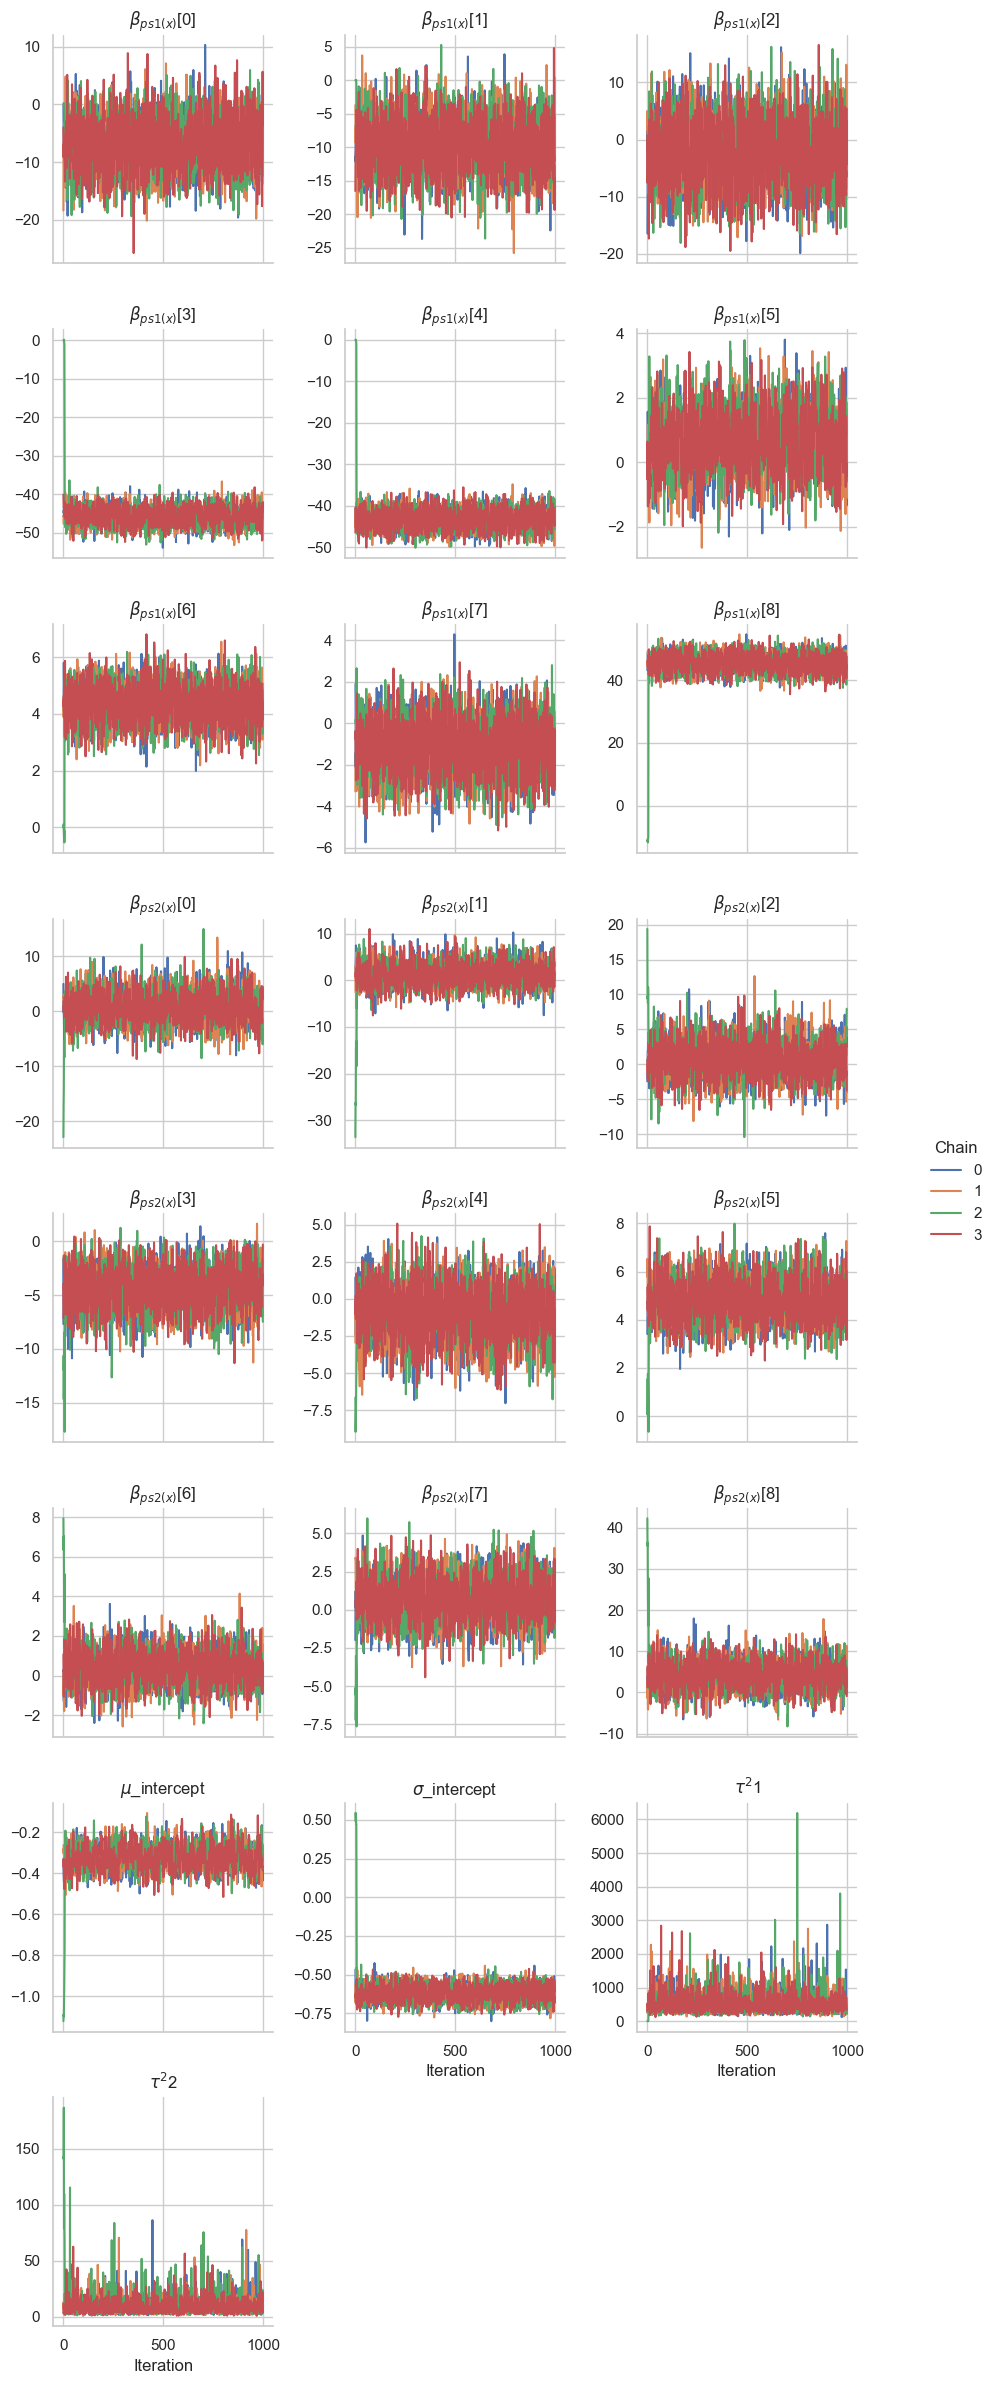

In [16]:
gs.plot_trace(results)

## Predictions

In [17]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [18]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ps1(x)", "ps2(x)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [19]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.227194,0.002757,0.052511,1.000524,3419.764533,3097.989357,0.001155,0.004372,2.149630,2.225927,2.305974,2.149554,2.305828,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.336287,0.002304,0.048002,1.000697,3419.929333,3179.734652,0.000964,0.002713,2.263556,2.335246,2.410491,2.264299,2.411112,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,2.445298,0.001939,0.044037,1.001083,3462.500347,3341.017132,0.000793,0.001464,2.376654,2.444538,2.515819,2.378634,2.517313,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,2.554142,0.001663,0.040775,1.000963,3588.214826,3586.906409,0.000689,0.000763,2.489278,2.553590,2.619900,2.492766,2.622982,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,2.662710,0.001474,0.038390,1.001057,3648.602468,3725.151601,0.000634,0.000605,2.601902,2.662859,2.724738,2.601292,2.724061,-1.923554


### Plot fitted functions

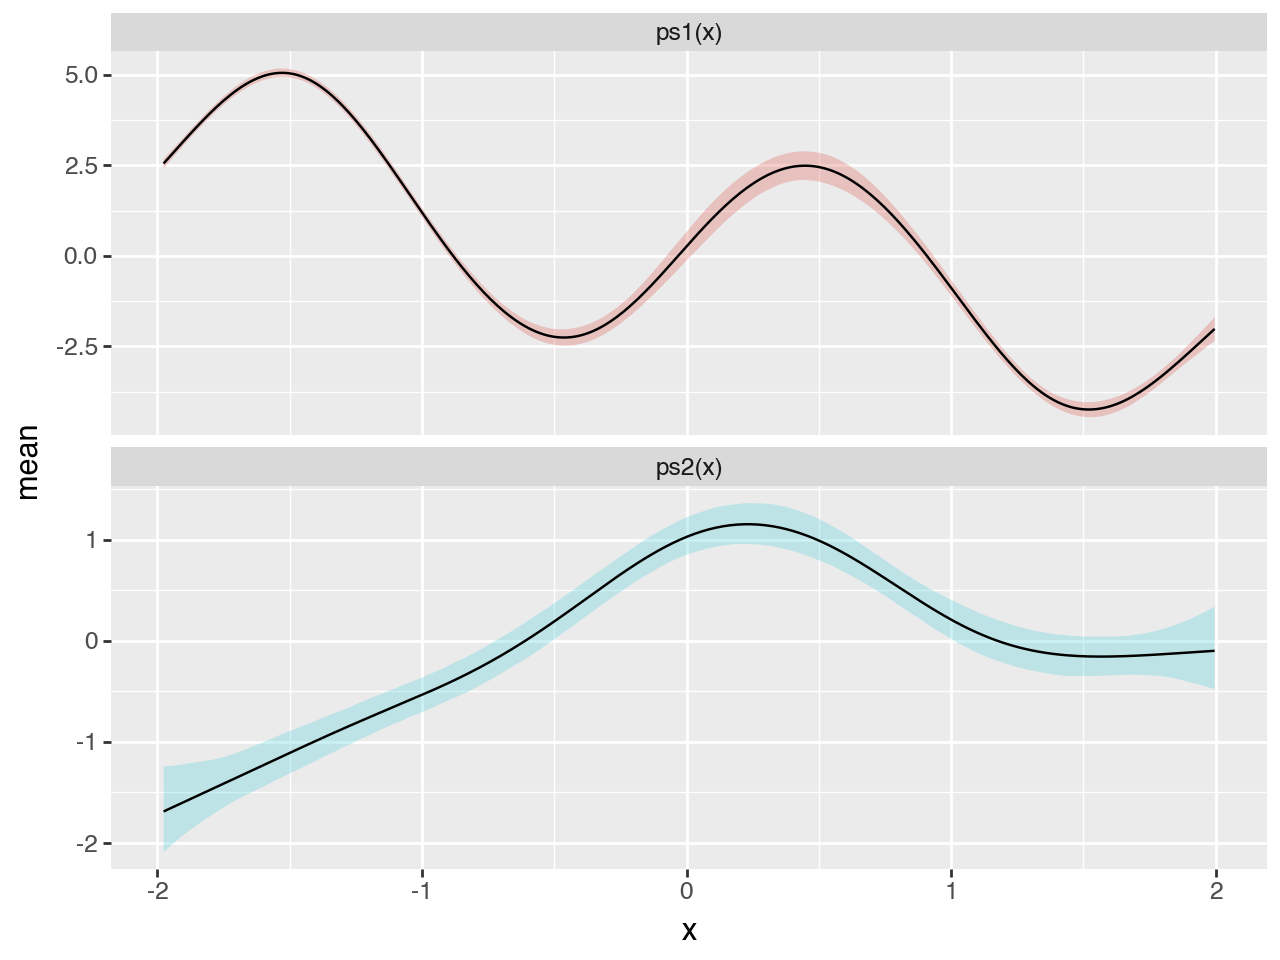

In [20]:
select = predictions_summary["variable"].isin(["ps1(x)", "ps2(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

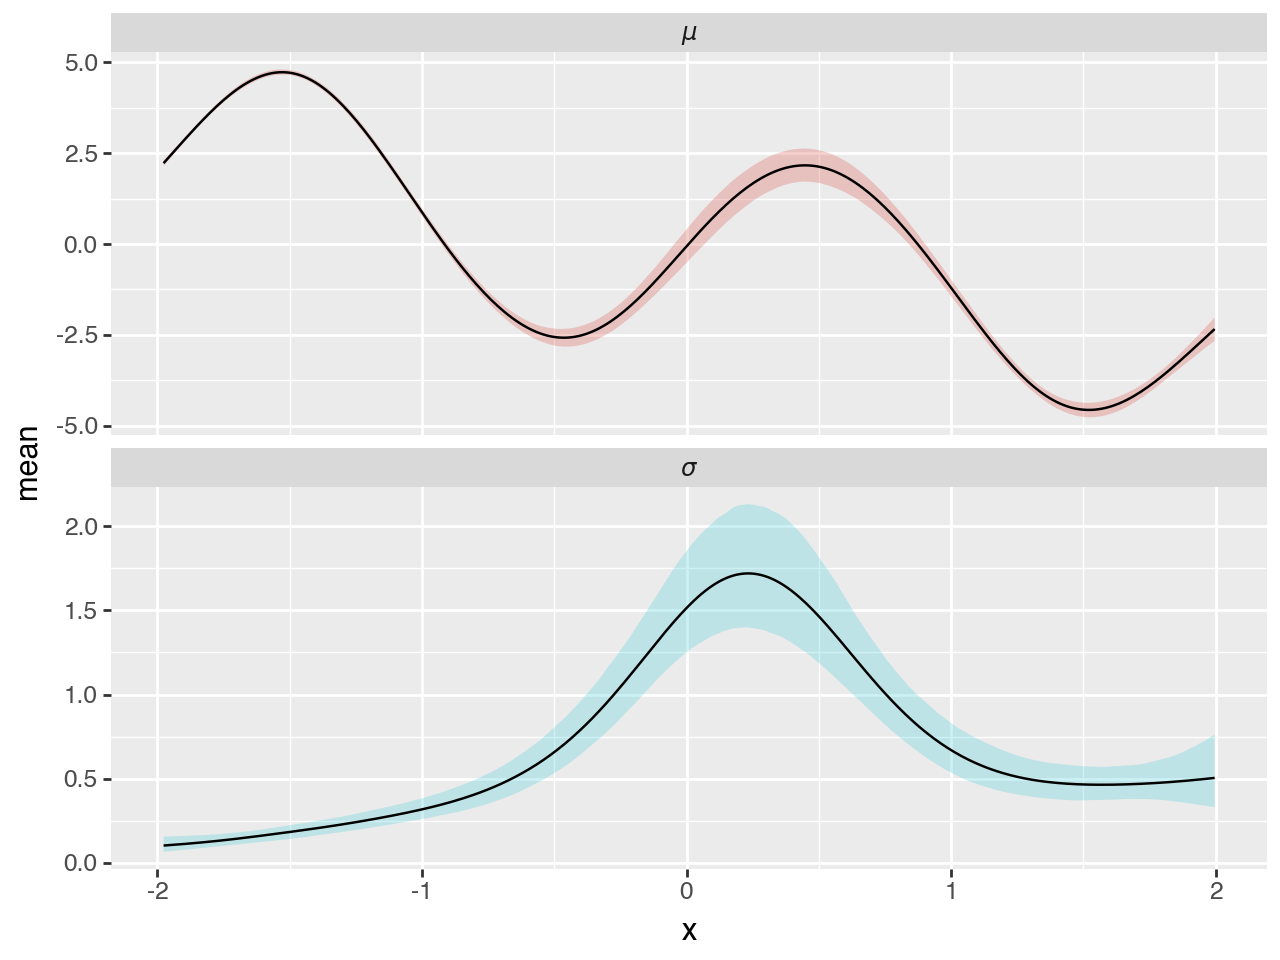

In [21]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

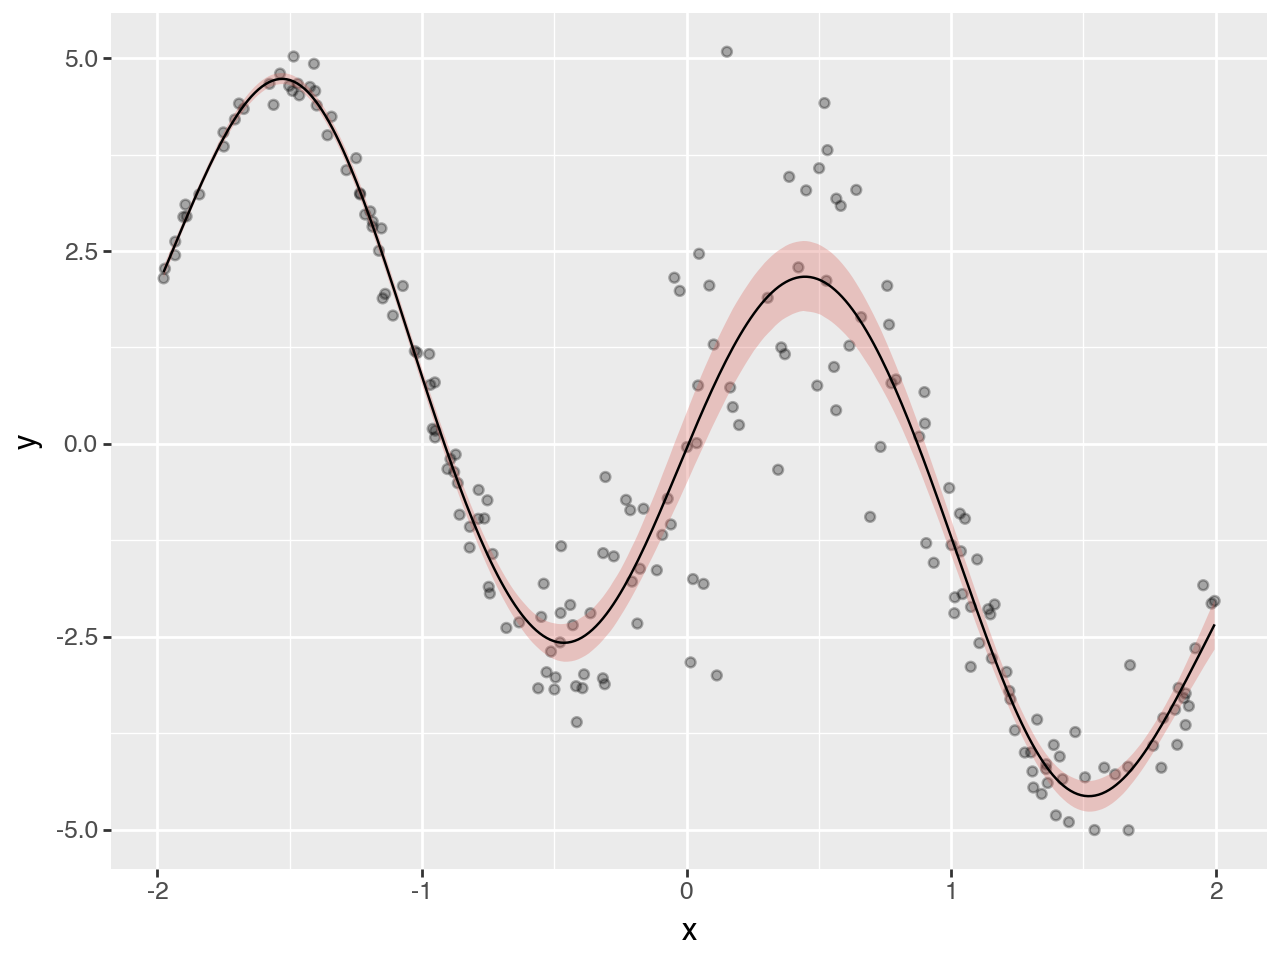

In [22]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [23]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.227194,0.103480,2.123714,2.330674
1,-1.963415,2.336287,0.104968,2.231319,2.441255
2,-1.950128,2.445298,0.106493,2.338805,2.551791
3,-1.936841,2.554142,0.108058,2.446084,2.662199
4,-1.923554,2.662710,0.109662,2.553047,2.772372
...,...,...,...,...,...
295,1.942956,-2.698350,0.496106,-3.194456,-2.202244
296,1.956243,-2.608820,0.498235,-3.107055,-2.110586
297,1.969530,-2.519106,0.500428,-3.019534,-2.018677
298,1.982817,-2.429290,0.502688,-2.931978,-1.926601


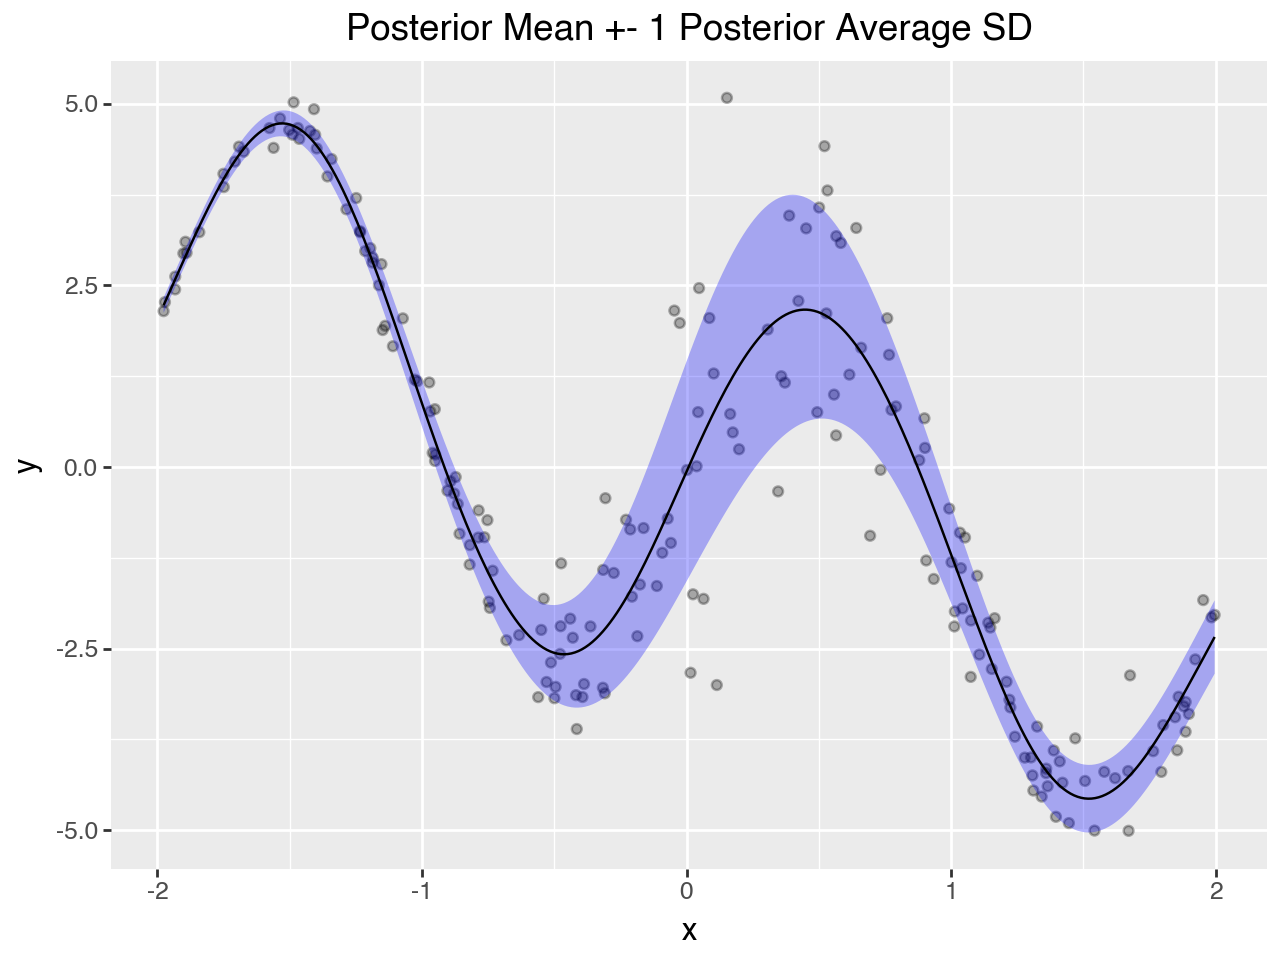

In [24]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [25]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [26]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [27]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

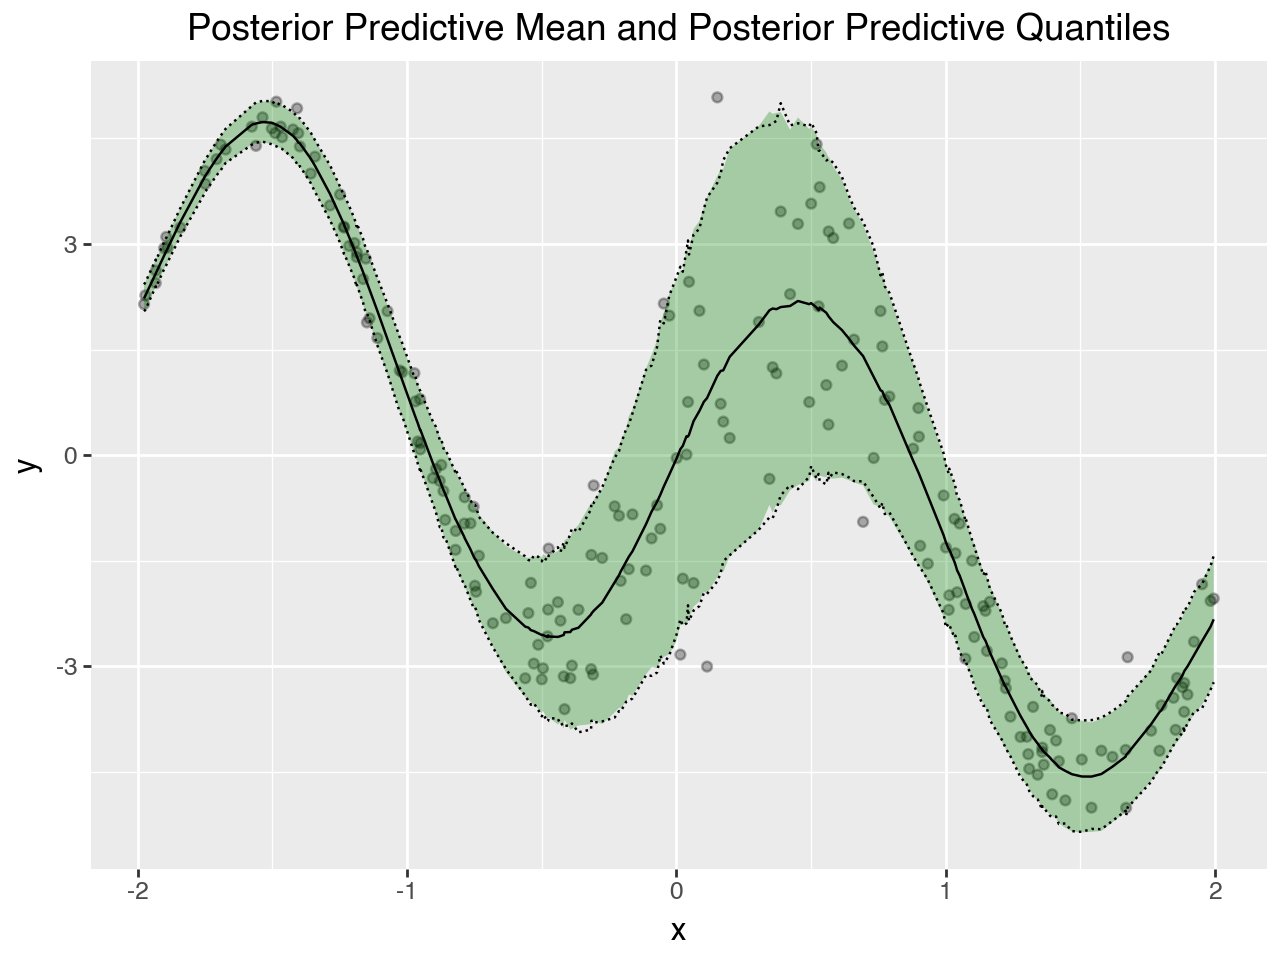

In [28]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

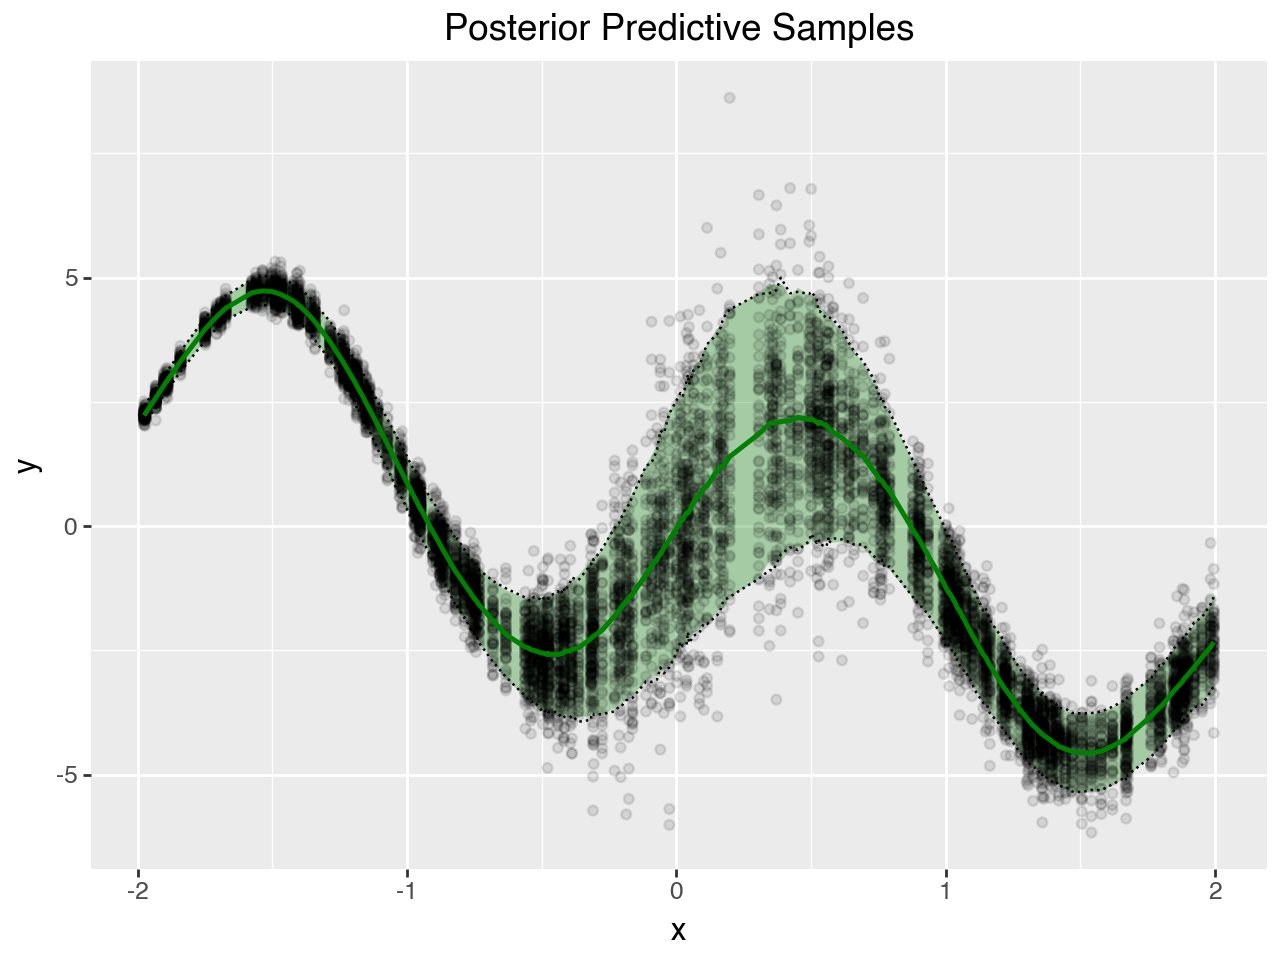

In [29]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)

In [30]:
from liesel_gam import plots

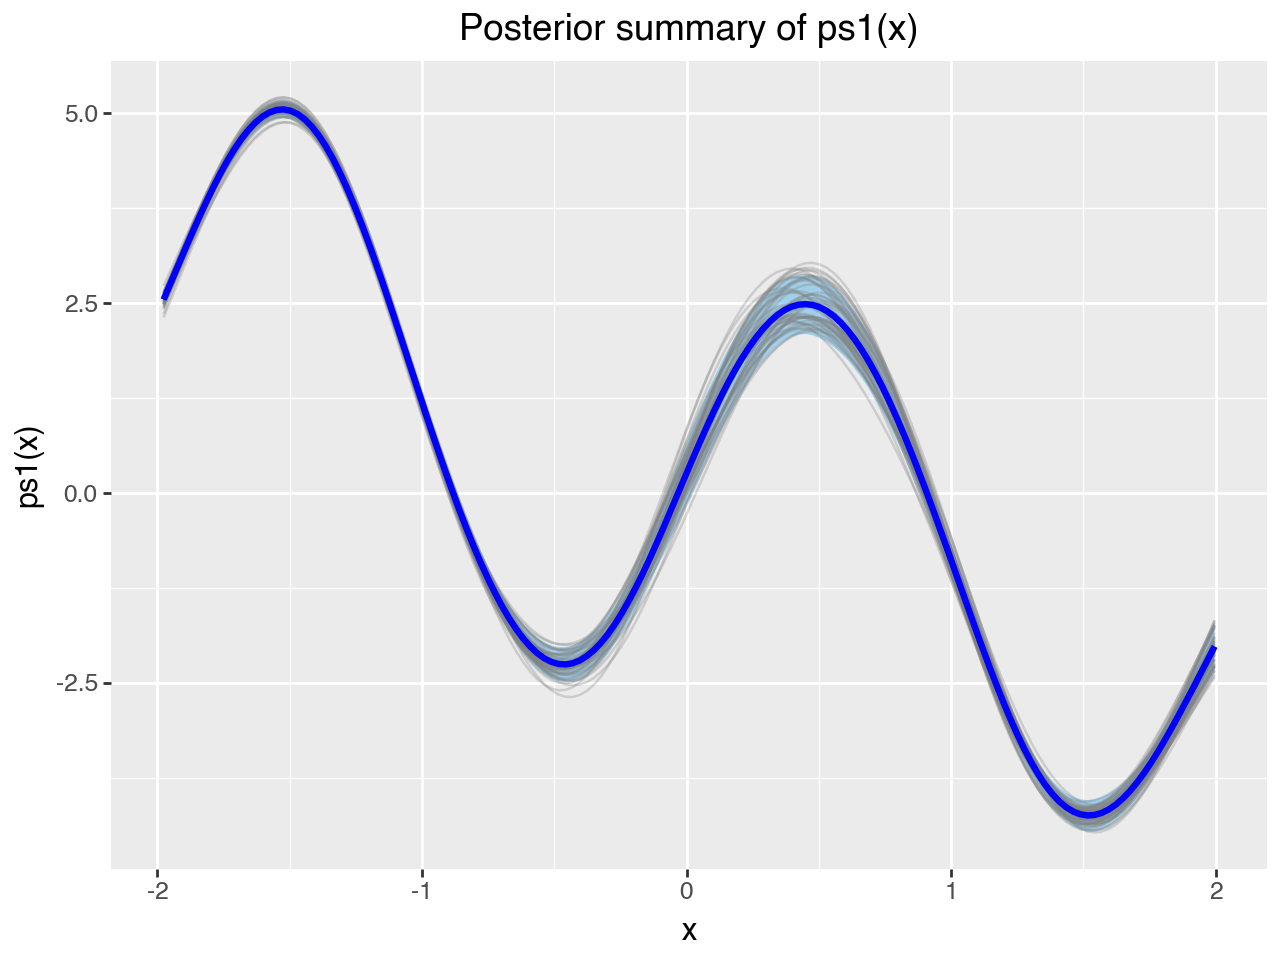

In [31]:
plots.plot_1d_smooth(loc.terms["ps1(x)"], samples)